In [ ]:
pip install pycparser
pip install torch_geometric


# data augmentation

In [ ]:
import random
import re
import copy
import pandas as pd
from pycparser import c_parser, c_ast

def parse_code(code):
    parser = c_parser.CParser()
    return parser.parse(code)

def rename_variables(node, var_mapping=None):
    if var_mapping is None:
        var_mapping = {}

    if isinstance(node, c_ast.Decl):
        if isinstance(node.name, str) and node.name not in var_mapping:
            new_name = f"var_{random.randint(1000, 9999)}"
            var_mapping[node.name] = new_name
        if node.name in var_mapping:
            node.name = var_mapping[node.name]

    for _, child in node.children():
        rename_variables(child, var_mapping)
    return var_mapping

def insert_dead_code(code):
    dead_code = f"int dummy_var = {random.randint(0, 100)};"
    return dead_code

def insert_random_noise(code):
    noise = ["// Random noise insertion", "// Temporary comment", "// Debugging: Check variable"]
    noise_point = random.randint(0, len(code))
    return code[:noise_point] + " " + random.choice(noise) + code[noise_point:]

def apply_code_formatting(code):
    code = re.sub(r'[\n\t]+', ' ', code)
    code = code.replace(' ', random.choice([' ', '\t', '\n']))
    return code

def augment_code(code, augmentation_count=5):
    augmented_codes = []
    for _ in range(augmentation_count):
        try:
            ast = parse_code(code)
        except Exception as e:
            print(f"Error parsing code: {e}")
            continue

        var_mapping = rename_variables(ast)
        code_with_dead_code = insert_dead_code(code)
        code_with_noise = insert_random_noise(code)
        formatted_code = apply_code_formatting(code)

        augmented_code = copy.deepcopy(code_with_noise) + " " + formatted_code + " " + code_with_dead_code
        augmented_codes.append(augmented_code)

    return augmented_codes

def generate_augmented_dataset(df, target_size=4500):
    augmented_samples = []
    while len(augmented_samples) < target_size:
        for sample in df['functionSource']:
            augmented_codes = augment_code(sample)
            augmented_samples.extend(augmented_codes)
            if len(augmented_samples) >= target_size:
                break

    random.shuffle(augmented_samples)

    return augmented_samples[:target_size]

def main():
    df = pd.read_csv("/content/469-1008.csv")
    target_size = 4500

    augmented_dataset = generate_augmented_dataset(df, target_size)

    augmented_df = pd.DataFrame(augmented_dataset, columns=['functionSource'])

    augmented_df.to_csv("469aug.csv", index=False)


if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/cwe_119_final.csv")
df2 = pd.read_csv("/content/cwe_120_final.csv")
df3 = pd.read_csv("/content/cwe_476_final.csv")
df4 = pd.read_csv("/content/cwe_other_final.csv")
df5 = pd.read_csv("/content/cwe_469_final.csv")


cwe_119 = df1.sample(n=4502, random_state=42)
cwe_120 = df2.sample(n=4496, random_state=42)
cwe_476 = df3.sample(n=4503, random_state=42)
cwe_other = df4.sample(n=4508, random_state=42)

cwe_119.reset_index(drop=True, inplace=True)
cwe_119.to_csv("cwe_119.csv", index=False)

cwe_120.reset_index(drop=True, inplace=True)
cwe_120.to_csv("cwe_120.csv", index=False)

cwe_476.reset_index(drop=True, inplace=True)
cwe_476.to_csv("cwe_476.csv", index=False)

cwe_other.reset_index(drop=True, inplace=True)
cwe_other.to_csv("cwe_other.csv", index=False)



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 22509 entries, 0 to 4507
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   functionSource  22509 non-null  object
 1   label           22509 non-null  object
dtypes: object(2)
memory usage: 527.6+ KB
None
label
CWE-other    4508
CWE-476      4503
CWE-119      4502
CWE-469      4500
CWE-120      4496
Name: count, dtype: int64


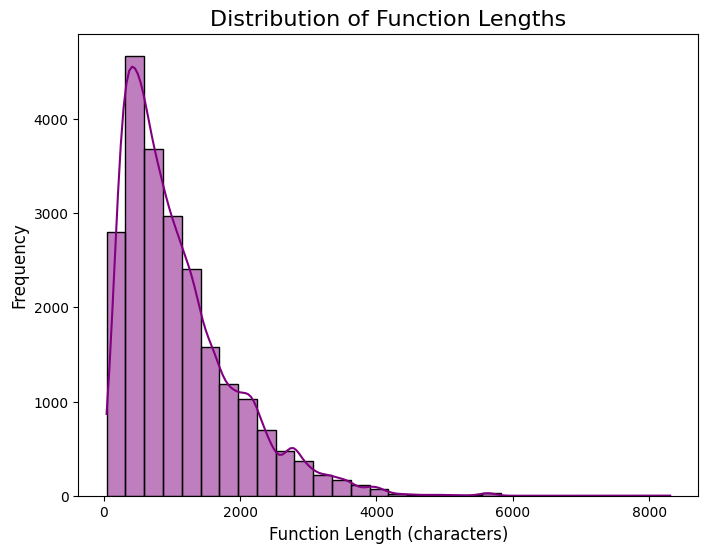

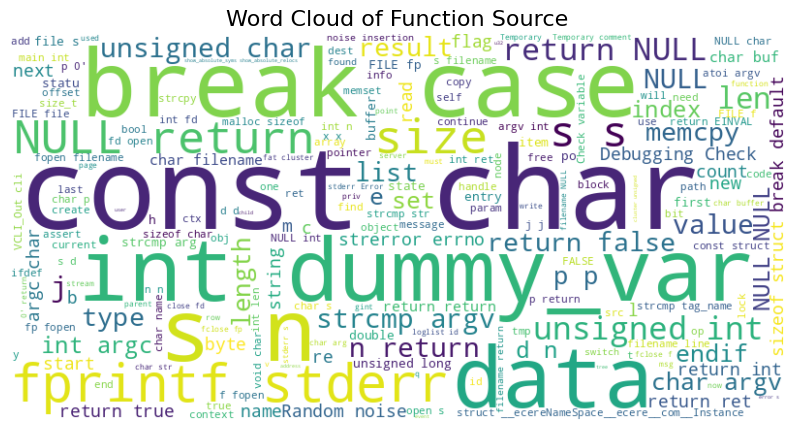

<ipython-input-3-0c235ae688a1>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y='function_length', palette="muted")


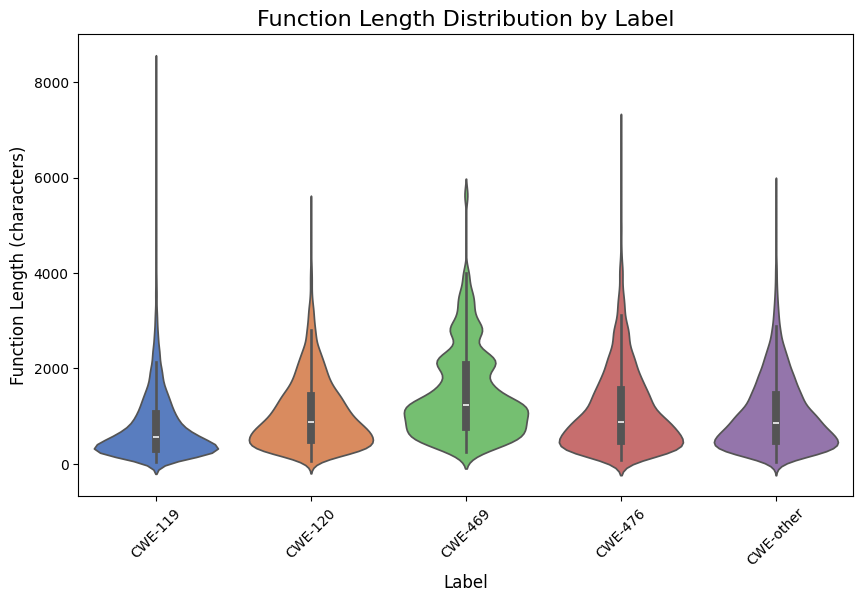

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


final_df = pd.concat([cwe_119, cwe_120, df5, cwe_476, cwe_other], axis=0)
final_df=final_df[['functionSource', 'label']]

df = final_df

print("Dataset Overview:")
print(df[['functionSource', 'label']].info())
print(df['label'].value_counts())

df['function_length'] = df['functionSource'].apply(lambda x: len(str(x)))
plt.figure(figsize=(8, 6))
sns.histplot(df['function_length'], bins=30, kde=True, color='purple')
plt.title("Distribution of Function Lengths", fontsize=16)
plt.xlabel("Function Length (characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig('function_length_distribution.png', dpi=300)
plt.show()

text = " ".join(df['functionSource'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Function Source", fontsize=16)
plt.savefig('word_cloud.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='label', y='function_length', palette="muted")
plt.title("Function Length Distribution by Label", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Function Length (characters)", fontsize=12)
plt.xticks(rotation=45)
plt.savefig('function_length_by_label.png', dpi=300)
plt.show()


### shuffle

In [ ]:
import pandas as pd
import numpy as np

text_df = final_df
vector_df = pd.read_csv('vector_dataset.csv')

assert len(text_df) == len(vector_df)

seed = 42
shuffle_indices = np.random.RandomState(seed).permutation(len(text_df))

shuffled_text_df = text_df.iloc[shuffle_indices].reset_index(drop=True)
shuffled_vector_df = vector_df.iloc[shuffle_indices].reset_index(drop=True)

shuffled_text_df.to_csv('shuffled_text_dataset.csv', index=False)
shuffled_vector_df.to_csv('shuffled_vector_dataset.csv', index=False)

print(shuffled_text_df.head())
print(shuffled_vector_df.head())


# jason to csv

In [5]:
import json
import csv

def json_to_csv(json_file, csv_file):
 
    with open(json_file, 'r') as infile:
        data = json.load(infile)

    fieldnames = ['instruction', 'input', 'output']

    with open(csv_file, 'w', newline='', encoding='utf-8') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)

        writer.writeheader()

        for item in data:
            row = {key: item[key] for key in fieldnames if key in item}
            writer.writerow(row)

    print(f"CSV file '{csv_file}' has been created successfully.")

json_file = '/Users/akter/Downloads/test_512 (8).json'  
csv_file = '/Users/akter/Downloads/juliet_test.csv'   
json_to_csv(json_file, csv_file)


CSV file '/Users/akter/Downloads/juliet_test.csv' has been created successfully.
